In [1]:
# Import packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import math
from datetime import date, timedelta, datetime
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout 
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Import ETF data
rye = pd.read_csv('rye.csv', parse_dates=['date'], index_col='date')
rye.dropna(inplace=True)

rye.head()

,open,high,low,close,adj close,volume
date,,,,,,
2006-11-07,49.560001,49.560001,49.119999,49.119999,38.082794,18000
2006-11-08,49.119999,49.119999,49.119999,49.119999,38.082794,0
2006-11-09,50.849998,50.849998,50.849998,50.849998,39.424061,1000
2006-11-10,50.049999,50.049999,49.849998,49.849998,38.648773,400
2006-11-13,49.849998,49.849998,49.849998,49.849998,38.648773,0


In [4]:
# Import brent oil data
brent = pd.read_csv('brent_spot_price_crude_oil.csv', parse_dates=['date'], index_col='date')
brent.columns = ['brent']

brent.head()

,brent
date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [5]:
# Merge ETF and brent oil data
model_df = rye[:]
model_df.insert(6, 'brent', brent['brent'])
model_df.dropna(inplace=True)

model_df.head()

,open,high,low,close,adj close,volume,brent
date,,,,,,,
2006-11-07,49.560001,49.560001,49.119999,49.119999,38.082794,18000,56.99
2006-11-08,49.119999,49.119999,49.119999,49.119999,38.082794,0,57.18
2006-11-09,50.849998,50.849998,50.849998,50.849998,39.424061,1000,59.72
2006-11-10,50.049999,50.049999,49.849998,49.849998,38.648773,400,59.18
2006-11-13,49.849998,49.849998,49.849998,49.849998,38.648773,0,56.88


In [6]:
# Define functions

## Plot time series
def plot_df(df, nrows, ncols, dpi=100):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 7))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i in range(0, df.shape[1]):
        ax = plt.subplot(nrows, ncols, i+1)
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.set_title(df.columns[i])
        ax.set_xlabel('Date')
        ax.set_ylabel(df.columns[i].capitalize())
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

## Plot training & validation loss values
def plot_loss(loss, epochs):
    fig, ax = plt.subplots(figsize=(16, 7), sharex=True)
    plt.plot(loss)
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.xlim(0, epochs)
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()
    
## Visualize the data
def plot_pred(df, start, title='Predictions vs Actuals'):
    df = df[start:]
    fig, ax1 = plt.subplots(figsize=(16, 7), sharex=True)
    plt.title(title)
    plt.ylabel('Value')
    plt.plot(df.index, df['close'])
    plt.plot(df.index, df['prediction'])
    plt.legend(['Actuals', 'Predictions'], loc='best')
    # Create the bar plot with the differences
    df.loc[df['difference'] >= 0, 'diff_color'] = "#2BC97A"
    df.loc[df['difference'] < 0, 'diff_color'] = "#C92B2B"
    # Create custom color range for positive and negative differences
    plt.bar(df.index[-len(df['difference'].dropna()):], df['difference'].dropna(), color=df['diff_color'].dropna())
    plt.grid()
    plt.show()

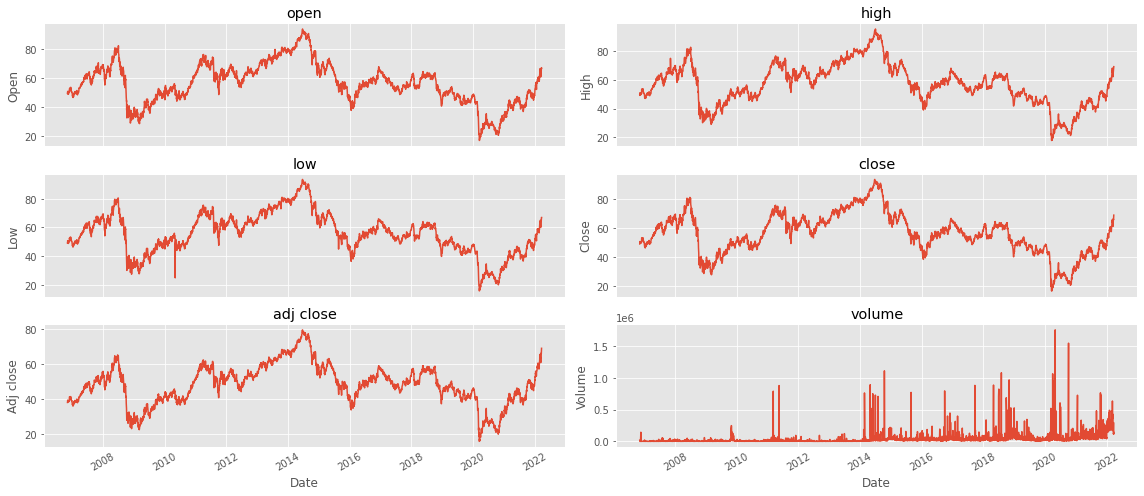

In [7]:
# Plot time series
plot_df(rye, 3, 2)

In [8]:
# Copy and remove date index
date_index = model_df.index
model_df = model_df.reset_index(drop=True).copy()
model_df.head()

,open,high,low,close,adj close,volume,brent
0,49.560001,49.560001,49.119999,49.119999,38.082794,18000,56.99
1,49.119999,49.119999,49.119999,49.119999,38.082794,0,57.18
2,50.849998,50.849998,50.849998,50.849998,39.424061,1000,59.72
3,50.049999,50.049999,49.849998,49.849998,38.648773,400,59.18
4,49.849998,49.849998,49.849998,49.849998,38.648773,0,56.88


In [9]:
# List of considered features
features = ['open', 'high', 'low', 'close', 'volume', 'brent']

print('Feature list: ')
print([f for f in features])

# Filter features and add a prediction column and set dummy values to prepare the data for scaling
model_df = model_df[features]
model_df['dummy'] = model_df['close']

model_df.tail()

Feature list: 
['open', 'high', 'low', 'close', 'volume', 'brent']


,open,high,low,close,volume,brent,dummy
3832,66.650002,68.089996,63.619999,65.540001,472000,133.18,65.540001
3833,63.410000,65.099998,62.349998,64.019997,636000,116.58,64.019997
3834,64.570000,66.320000,64.000000,66.129997,448200,114.54,66.129997
3835,65.360001,66.349998,65.029999,65.300003,354800,118.11,65.300003
3836,64.209999,64.209999,62.180000,63.169998,428100,110.39,63.169998


In [10]:
# Get the number of rows in the data
nrows = model_df.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(model_df)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
np_close_scaled = scaler_pred.fit_transform(pd.DataFrame(model_df['close']))

(3837, 7)


In [11]:
# Set split percentage
train_per = 0.8

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Set the prediction interval to 1 week
# pred_int = 5
# Set the prediction interval to 1 day
pred_int = 1

# Prediction Index
index_close = model_df.columns.get_loc("close")

# Split the training data into train and train data sets
# # As a first step, we get the number of rows to train the model on 80% of the data 
# train_data_len = math.ceil(np_data_scaled.shape[0]*train_per)

# Create the training and test data
train_data = np_data_scaled[0:math.ceil(np_data_scaled.shape[0]*train_per)]
test_data = np_data_scaled[math.ceil(np_data_scaled.shape[0]*train_per)-sequence_length:]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len-pred_int+1):
        x.append(data[i-sequence_length:i, :]) # contains sequence_length values 0-sequence_length * columns
        y.append(data[i+pred_int-1, index_close]) # contains the prediction values for validation, for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print('Train X shape:', x_train.shape)
print('Train Y shape:', y_train.shape)
print('Test X shape:', x_test.shape)
print('Test Y shape:', y_test.shape)

Train X shape: (3020, 50, 7)
Train Y shape: (3020,)
Test X shape: (767, 50, 7)
Test Y shape: (767,)


In [12]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

350 50 7


In [13]:
# Training the model
epochs = 50
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/50
189/189 [==============================] - 6s 16ms/step - loss: 0.0038 - val_loss: 6.8132e-04
Epoch 2/50
189/189 [==============================] - 3s 15ms/step - loss: 6.6211e-04 - val_loss: 4.4326e-04
Epoch 3/50
189/189 [==============================] - 3s 14ms/step - loss: 6.0950e-04 - val_loss: 4.2642e-04
Epoch 4/50
189/189 [==============================] - 3s 14ms/step - loss: 5.4836e-04 - val_loss: 4.0127e-04
Epoch 5/50
189/189 [==============================] - 3s 14ms/step - loss: 4.3431e-04 - val_loss: 3.7737e-04
Epoch 6/50
189/189 [==============================] - 3s 14ms/step - loss: 4.2889e-04 - val_loss: 3.6934e-04
Epoch 7/50
189/189 [==============================] - 3s 14ms/step - loss: 3.9847e-04 - val_loss: 2.8090e-04
Epoch 8/50
189/189 [==============================] - 3s 14ms/step - loss: 3.4018e-04 - val_loss: 4.2009e-04
Epoch 9/50
189/189 [==============================] - 3s 14ms/step - loss: 3.1719e-04 - val_loss: 2.5866e-04
Epoch 10/50
189/189 [==

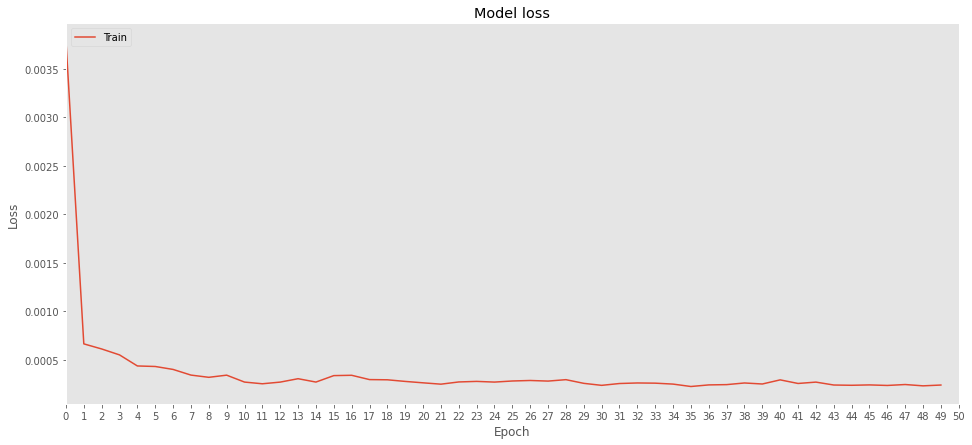

In [14]:
# Plot training & validation loss values
plot_loss(history.history["loss"], epochs)

In [15]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 0.78
Mean Absolute Percentage Error (MAPE): 2.24 %
Median Absolute Percentage Error (MDAPE): 1.47 %


In [16]:
# Reverse the interval of prediction
y_pred = y_pred.ravel() if pred_int == 1 else y_pred.ravel()[:-pred_int]

# Insert prediction and difference into the dataframe
model_df.insert(7, 'prediction', np.nan)
model_df.iloc[-len(y_pred):, 7] = y_pred
model_df.insert(8, 'difference', model_df['prediction'] - model_df['close'], True)
model_df.index = date_index

model_df.tail()

,open,high,low,close,volume,brent,dummy,prediction,difference
date,,,,,,,,,
2022-03-08,66.650002,68.089996,63.619999,65.540001,472000,133.18,65.540001,64.853546,-0.686455
2022-03-09,63.410000,65.099998,62.349998,64.019997,636000,116.58,64.019997,65.111992,1.091995
2022-03-10,64.570000,66.320000,64.000000,66.129997,448200,114.54,66.129997,63.289570,-2.840427
2022-03-11,65.360001,66.349998,65.029999,65.300003,354800,118.11,65.300003,65.436180,0.136177
2022-03-14,64.209999,64.209999,62.180000,63.169998,428100,110.39,63.169998,64.955872,1.785873


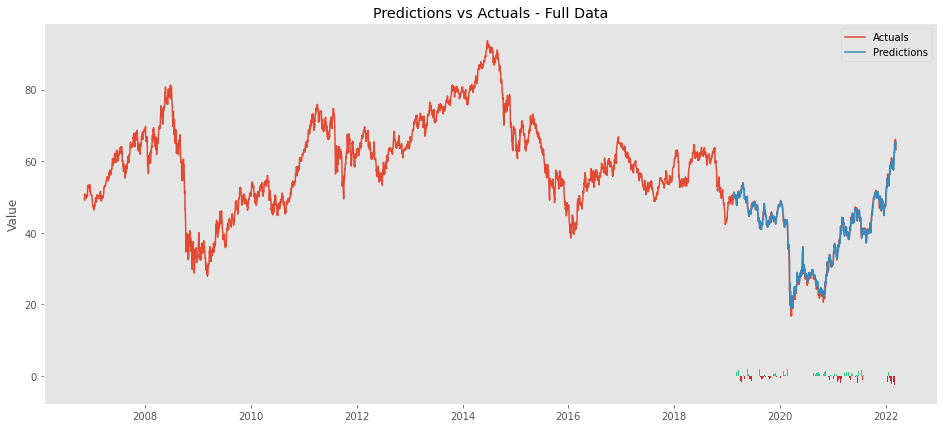

In [17]:
# Visualize the data
plot_pred(model_df, 0, title='Predictions vs Actuals - Full Data')

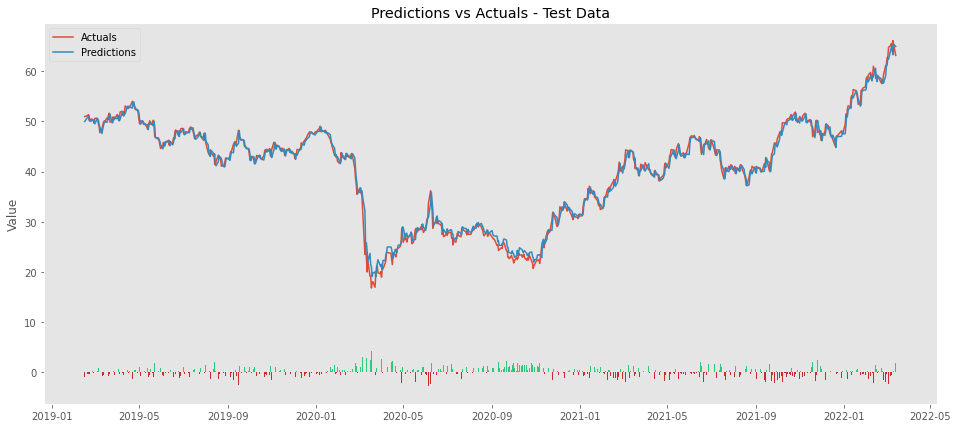

In [18]:
# Visualize the data
plot_pred(model_df, len(model_df) - len(y_pred.ravel()), title='Predictions vs Actuals - Test Data')

In [19]:
# Get the test data and scale
df_temp = model_df[-sequence_length:][features]
df_temp['dummy'] = df_temp['close']
df_temp_scaled = scaler.transform(df_temp.values)
df_temp_test = []
df_temp_test.append(df_temp_scaled)

# Predict
pred_price_scaled = model.predict(np.array(df_temp_test))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print single-day forecast
price_today = np.round(df_temp['close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percentage = np.round(100 - (price_today * 100) / predicted_price, 2)
plus = '+'; minus = ''
print(f'The close price for ETF on {str(pd.to_datetime(df_temp[-1:].index.values[0]).date())} is {price_today}')
print(f'The predicted close price for the next day is {predicted_price}')
# print(f'The predicted close price for the next {pred_int} day is {predicted_price}')

The close price for ETF on 2022-03-14 is 63.17
The predicted close price for the next day is 62.5
